## Simulation generator for XClone

In [1]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

%aimport xclone_config
project_config = xclone_config
os.chdir(project_config.ROOT)

from collections import Counter, defaultdict, OrderedDict
import itertools
from itertools import product as cartesian
import multiprocessing as mp
import pickle

import numba
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as sps
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

import toolkit
import util
from workspace.workspace_manager import WorkspaceManager

sns.set()

workspace = {}
for modality in ["scDNA", "scRNA"]:
    workspace.update({ 
        modality : WorkspaceManager(
            task_name="classification",
            experiment_info={
                "sample" : "STP_G&T",
                "modality" : modality
            },
            verbose=True
        )
    })
    workspace[modality].load_workspace()
    
assert workspace["scDNA"].experiment_info["sample"]\
        == workspace["scRNA"].experiment_info["sample"],\
    "scDNA and scRNA workspaces store different samples"

sample_tag = workspace["scDNA"].experiment_info["sample"]
print(f"Currently working on {sample_tag}")

Currently working on STP_G&T


### Loading G&T data

In [2]:
from scipy.sparse import load_npz

# D_DNA = load_npz(workspace["scDNA"].dir + "/top_coverage_in_cluster_block_DP.npz").todense()
# D_RNA = load_npz(workspace["scRNA"].dir + "/top_coverage_in_cluster_block_DP.npz").todense()
D_DNA = util.pickle_load(workspace["scDNA"].dir + "/top_coverage_in_cluster_D_DNA.pkl")
D_RNA = util.pickle_load(workspace["scDNA"].dir + "/top_coverage_in_cluster_D_RNA.pkl")

CNV_DNA = util.pickle_load(workspace["scDNA"].dir + "/top_coverage_in_cluster_CNV_DNA.pkl")
I_DNA = util.pickle_load(workspace["scDNA"].dir + "/top_coverage_in_cluster_I_DNA.pkl")
tau = util.pickle_load(workspace["scDNA"].dir + "/tau.pkl")
T = util.pickle_load(workspace["scDNA"].dir + "/top_coverage_in_cluster_T.pkl")

print(f"RAW, ({I_DNA.size} cells)")
display(pd.DataFrame(
    np.column_stack((
        np.arange(CNV_DNA.shape[1]), 
        np.round(100 * np.mean(np.isnan(CNV_DNA), axis=0))
    )), columns=["cluster", "% of NaNs"]
))

# cells_to_keep = (I_DNA != 6)
# clusters_to_keep = [0, 1, 2, 3, 4, 5, 7, 8]
# D_DNA = D_DNA[:, cells_to_keep]
# D_RNA = D_RNA[:, cells_to_keep]
# I_DNA = I_DNA[cells_to_keep]
# I_DNA[I_DNA > 6] = I_DNA[I_DNA > 6] - 1
# CNV_DNA = CNV_DNA[:, clusters_to_keep]
# T = T[:, clusters_to_keep]

print(f"W/O cluster 6 of dead cells ({I_DNA.size} cells remain)")
display(pd.DataFrame(
    np.column_stack((
        np.arange(CNV_DNA.shape[1]), 
        np.round(100 * np.mean(np.isnan(CNV_DNA), axis=0))
    )), columns=["cluster", "% of NaNs"]
))

# print(f"RAW: ({D_DNA.shape[0]} blocks in each cell)")

# idx = np.all(T > 0, axis=1) * np.all(~np.isnan(T), axis=1)

# T = T[idx, :]
# D_RNA = np.nan_to_num(D_RNA[idx, :])
# D_DNA = np.nan_to_num(D_DNA[idx, :])

# print(f"ONLY NON-MISSING: ({D_DNA.shape[0]} blocks in each cell)")

RAW, (7 cells)


,cluster,% of NaNs
0,0.0,0.0
1,1.0,0.0
2,2.0,0.0
3,3.0,0.0
4,4.0,0.0
5,5.0,0.0
6,6.0,0.0


W/O cluster 6 of dead cells (7 cells remain)


,cluster,% of NaNs
0,0.0,0.0
1,1.0,0.0
2,2.0,0.0
3,3.0,0.0
4,4.0,0.0
5,5.0,0.0
6,6.0,0.0


In [5]:
%%time
%load_ext autoreload
%autoreload 2

import classification.xclone_model.xclone_routines as xclone_routines
from classification.xclone_model.xclone_distrib import XCloneDistrib
from classification.xclone_model.xclone_gibbs_sampler import XCloneGibbsSampler
from classification.xclone_model.xclone_engine import XCloneEngine
from classification.xclone_model.xclone_criterions import accuracy_criterion, loglik_criterion

n_cell = 100
simulation_kwargs = {
    "tau" : tau,
    "T_mat" : T,
    "D_DNA_seed" : np.nan_to_num(D_DNA),
    "D_RNA_seed" : np.nan_to_num(D_RNA),
    "n_cell" : n_cell,
    "random_seed" : 1337
}

simulated_datadict = xclone_routines.simulate_G_T(**simulation_kwargs)
simulated_params = XCloneDistrib.from_dict(simulated_datadict)

sampler = XCloneGibbsSampler()

xclone = XCloneEngine(
    workspace_dict=workspace,
    params=simulated_params,
    sampler=sampler,
    criterion=loglik_criterion,
    report_dir="/icgc/dkfzlsdf/analysis/B260/users/v390v/"\
                "xclone/data/tmp/xclone/STP_G&T/"\
                f"18_11_2019/evening_run/simulated_data/{n_cell}_cells_stat_phased_genes/DNA_vs_RNA",
    verbose=True
)
xclone

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/lib/classification/xclone_model/xclone_routines.py:489: RuntimeWarning: invalid value encountered in less
  A_DNA = np.random.binomial(D_DNA, X_DNA)
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/lib/classification/xclone_model/xclone_routines.py:489: RuntimeWarning: invalid value encountered in greater
  A_DNA = np.random.binomial(D_DNA, X_DNA)
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/lib/classification/xclone_model/xclone_routines.py:495: RuntimeWarning: invalid value encountered in less
  A_RNA = np.random.binomial(D_RNA, X_RNA)
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/lib/classification/xclone_model/xclone_routines.py:495: RuntimeWarning: invalid value encountered in greater
  A_RNA = np.random.binomial(D_RNA, X_RNA)


CPU times: user 8.49 s, sys: 4.38 s, total: 12.9 s
Wall time: 6.84 s


XCloneEngine, 2019-2020, Stegle Lab
Report dir: /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/xclone/STP_G&T/18_11_2019/evening_run/simulated_data/100_cells_stat_phased_genes/DNA_vs_RNA
This instance was created on 18/11/2019 18:16:32
Criterion: <function loglik_criterion at 0x7fc2a437d9d8>
DNA sample: STP_G&T
Cells in DNA sample: 100
RNA sample: STP_G&T
Cells in RNA sample: 100
Total number of CNV-haploblocks: 7921
Number of clones: 7
0 fitting iterations already passed
Sampler used: <class 'classification.xclone_model.xclone_gibbs_sampler.XCloneGibbsSampler'>
Initial total loglikelihood: -4.248700123984728
Current best total loglikelihood: -39.92015233566123

In [6]:
new_params = xclone._sampler.sample(xclone._params)
new_params.total_loglikelihood()

-20.711980126098627

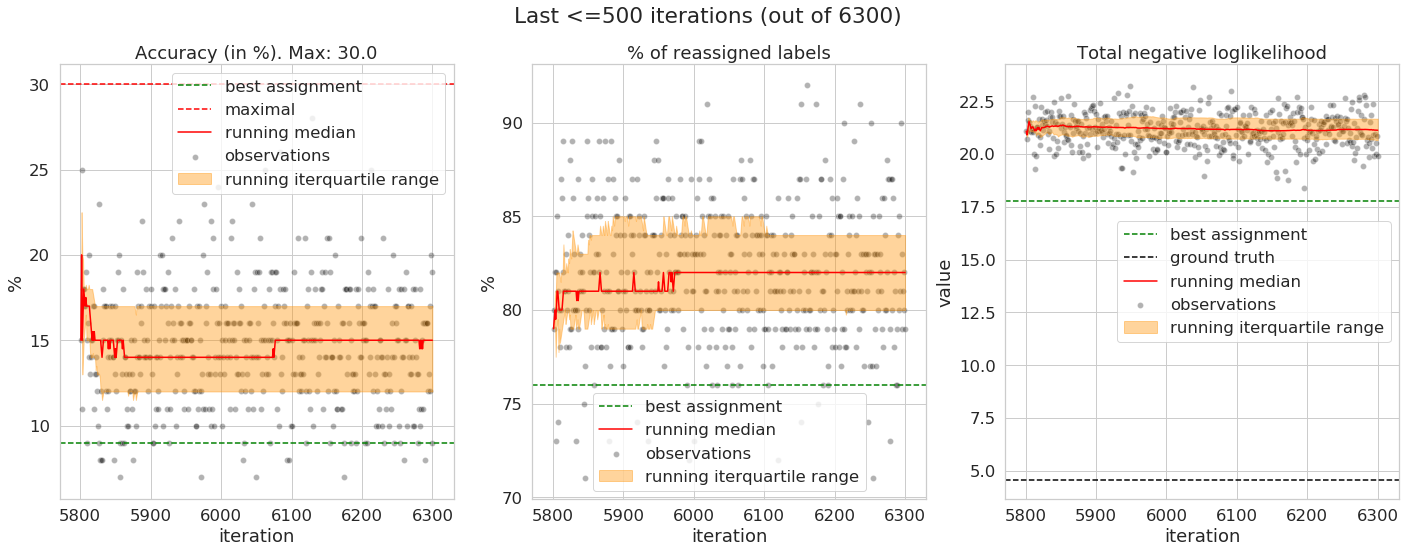

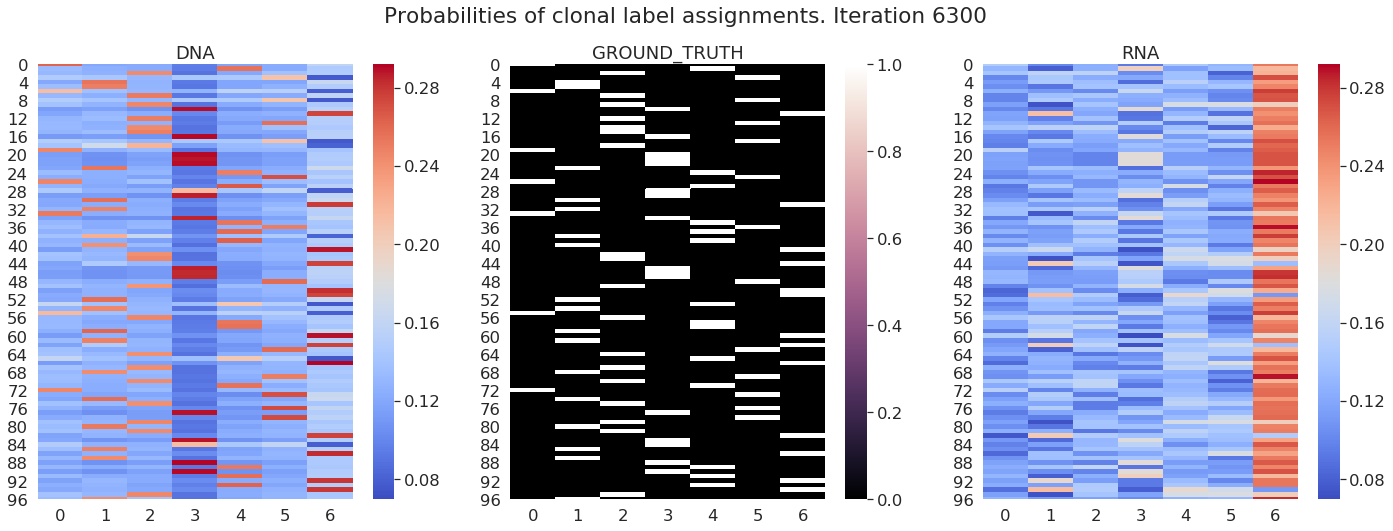

[ -3.46740167 -14.32427559]


In [ ]:
%%time
%matplotlib inline

from classification.xclone_model.xclone_diagnostics import GTConvergenceTracker
sns.set(font_scale=1.5, style="whitegrid")

xclone.fit(10000, GTConvergenceTracker())

In [474]:
print(
    "Final accuracy {:.2f}%. The most probable clone is chosen for each cell."\
    .format(100 * np.mean(xclone._params.I_DNA 
                          == xclone._params.most_likely_labels()))
)

Final accuracy 93.00%. The most probable clone is chosen for each cell.


In [485]:
# statistics and machine learning
from sklearn.metrics import confusion_matrix
# visualizations
import seaborn as sns

def plot_confmat(y_true, y_pred, cluster_labels, ax, context_info):
    confmat = confusion_matrix(y_true, y_pred)
    sns.set()
    ax.set_title(''.join(
        f"{key}: {value}.\n"
        for key, value in context_info.items()
    ), weight="bold")
    sns.heatmap(
        confmat,
        ax=ax,
        annot=True,
        xticklabels=cluster_labels,
        yticklabels=cluster_labels,
    )
    

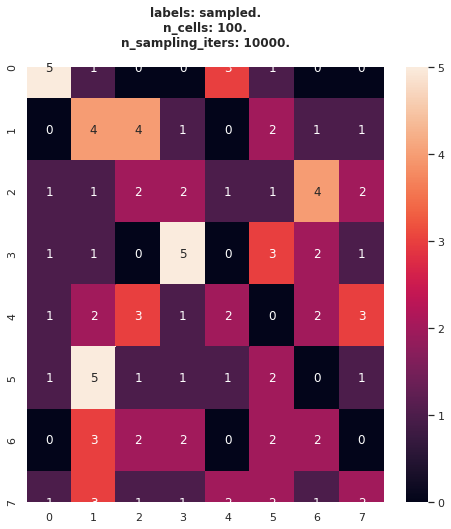

In [486]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_confmat(
    y_true=xclone._params.I_DNA, 
    y_pred=xclone._params.I_RNA,
    cluster_labels=np.arange(8),
    ax=ax,
    context_info={
        "labels" : "sampled",
        "n_cells" : n_cell,
        "n_sampling_iters" : 10000
    }
)

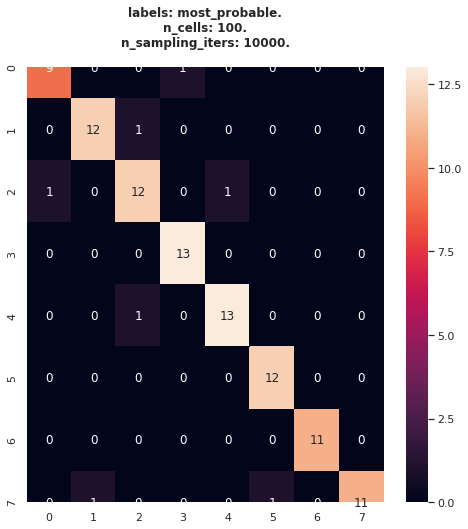

In [487]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_confmat(
    y_true=xclone._params.I_DNA, 
    y_pred=xclone._params.most_likely_labels(),
    cluster_labels=np.arange(8),
    ax=ax,
    context_info={
        "labels" : "most_probable",
        "n_cells" : n_cell,
        "n_sampling_iters" : 10000
    }
)